In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


In [2]:
input = './spaceship-titanic.zip'
output = './input'
def unzip(input, output):
    import zipfile
    with zipfile.ZipFile(input, 'r') as zip_ref:
        zip_ref.extractall(output)

In [3]:
df = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


- `PassengerId` - A unique Id for each passenger. Each Id takes the form `gggg_pp` where `gggg` indicates a group the passenger is travelling with and `pp` is their number within the group. People in a group are often family members, but not always.
- `HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.
- `CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- `Cabin` - The cabin number where the passenger is staying. Takes the form `deck/num/side`, where `side` can be either `P` for _Port_ or `S` for _Starboard_.
- `Destination` - The planet the passenger will be debarking to.
- `Age` - The age of the passenger.
- `VIP` - Whether the passenger has paid for special VIP service during the voyage.
- `RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the _Spaceship Titanic_'s many luxury amenities.
- `Name` - The first and last names of the passenger.
- `Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [5]:
df.columns = [col.lower() for col in df]

## Handling Nulls

The existence of null values in a dataset does not play nicely with machine learning models, therefore it is important to remove them.  The easiest method of removing nulls is to simply drop them from the dataset.  However, I'm a hoarder and I don't like dropping data when I don't need to so I'll be using a strategy known as **imputing**, where we manufacture data using a 'best guess' approach.

The figure below shows us a decent approximation of how the nulls are distributed among the dataset.

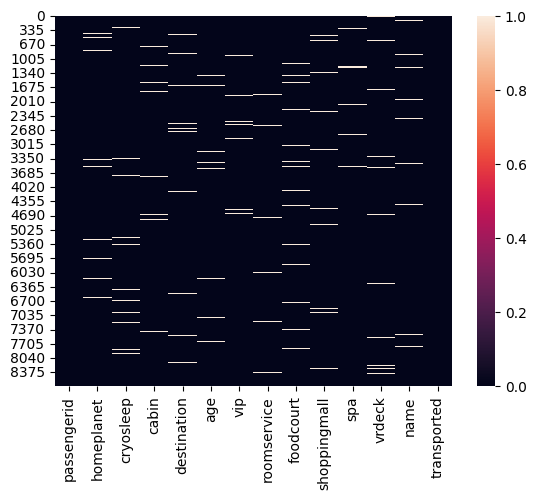

In [6]:
sns.heatmap(df.isna())
plt.show()

I also like to get the actual counts of null cells for each column.

In [7]:
df.isna().sum()

passengerid       0
homeplanet      201
cryosleep       217
cabin           199
destination     182
age             179
vip             203
roomservice     181
foodcourt       183
shoppingmall    208
spa             183
vrdeck          188
name            200
transported       0
dtype: int64

In [8]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [9]:
df[df.isna().any(axis=1)]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
10,0008_02,Europa,True,B/1/P,TRAPPIST-1e,34.0,False,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,True
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
23,0020_03,Earth,True,E/0/S,55 Cancri e,29.0,False,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,Chain Reedectied,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8675,9259_01,Earth,NaN,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True


Quite a few of these null values can be confidently inferred and thus imputed.  Take row 7 for example, if we know a passenger is in cryosleep then they are very unlikely to have spent money at the VRdeck.  Inversely if they spent money anywhere then they were probably not in cryosleep (row 8675).

For the passengers with null values in `homeplanet` I can check to see if the group number in their id has that information and impute the value that way.  I think KNN imputing makes sense here since the group would be in numerical format.

### Imputing cryosleep status

This one seems to be the easiest to infer so I'll start here.  Just by looking at the data above I've noticed that the passengers in cryosleep seem to have a habit of holding onto their money.  That makes sense to me.  After all, it's hard to imagine a person who has been frozen wandering over to the food court for a quick snack.

We can verify this theory pretty easily by summing up all of the spending from all of the cryosleep passengers.

In [10]:
# Save myself some typing by throwing these columns into a list
spending_cols = ['roomservice','foodcourt','shoppingmall','spa','vrdeck']

In [11]:
# Make sure there aren't any anomalies
df[df['cryosleep'] == True][spending_cols].sum()

roomservice     0.0
foodcourt       0.0
shoppingmall    0.0
spa             0.0
vrdeck          0.0
dtype: float64

Now that I'm confident of my theory, I can ask a simple question of each row... did this passenger spend a single dollar?

In [12]:
# Generate a boolean mask for filtering
df[spending_cols].sum(axis=1) > 0

0       False
1        True
2        True
3        True
4        True
        ...  
8688     True
8689    False
8690     True
8691     True
8692     True
Length: 8693, dtype: bool

And I can put that question to work to impute the values of the cryosleep column.

In [13]:
# If they spent anything, they probably aren't in cryosleep
df.loc[(df.cryosleep.isna()) & (df[spending_cols].sum(axis=1) > 0), 'cryosleep'] = False

In [14]:
# If they didn't spend anything, they probably are in cryosleep
df.loc[(df.cryosleep.isna()) & (df[spending_cols].sum(axis=1) == 0), 'cryosleep'] = True

Voila!

In [15]:
# Verifying we imputed every last null
df.cryosleep.isna().sum()

0

### Imputing spending of cryosleep passengers

Building off of the same logic as before, we know that it's not likely for cryosleep passengers to spend money, so we can simply impute any missing values as 0.

In [16]:
# Set it all to 0.0 to remove the nulls
df.loc[df.cryosleep == True, spending_cols] = 0.0

In [17]:
df[df.isna().any(axis=1)]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
15,0012_01,Earth,False,NaN,TRAPPIST-1e,31.0,False,32.0,0.0,876.0,0.0,0.0,Justie Pooles,False
16,0014_01,Mars,False,F/3/P,55 Cancri e,27.0,False,1286.0,122.0,NaN,0.0,0.0,Flats Eccle,False
27,0022_01,Mars,False,D/0/P,TRAPPIST-1e,21.0,False,980.0,2.0,69.0,0.0,0.0,NaN,False
35,0031_03,Mars,False,F/9/P,TRAPPIST-1e,20.0,False,NaN,0.0,1750.0,990.0,0.0,Dontch Datie,True
38,0036_01,Earth,False,F/8/S,55 Cancri e,15.0,NaN,0.0,492.0,48.0,20.0,401.0,Marina Leodger,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True
8667,9250_01,Europa,False,E/597/P,TRAPPIST-1e,29.0,False,0.0,2972.0,NaN,28.0,188.0,Chain Reedectied,True
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False
8675,9259_01,Earth,False,F/1893/P,TRAPPIST-1e,44.0,False,1030.0,1015.0,0.0,11.0,NaN,Annah Gilleyons,True


### Imputing spending of non-cryosleep passengers

For everyone else's spending habits I think that it's a safe assumption that people spend simalarly to the people with similar spending habits as them. Therefore I think KNN imputing makes a lot of sense.

When I can, I like to use sklearn methods to accomplish these tasks.  This is because they are very good at preventing data spillage which will be important later when we try to repeat the process on the test dataset.  Therefore, I'll use sklearn's KNNImputer for this task.  KNN is a method that deals with distances, and normally it is important to scale the data, but here there's no need to scale the data because all of the columns are in the same units of measurement.

In [18]:
from sklearn.impute import KNNImputer
# Fit on training data
spending_imputer = KNNImputer()
spending_imputer.fit(df[spending_cols])

# Assign predictions back to the original DataFrame
imputed_spending_values = spending_imputer.transform(df[spending_cols])
df.loc[:, spending_cols] = imputed_spending_values

In [19]:
df.isna().sum()

passengerid       0
homeplanet      201
cryosleep         0
cabin           199
destination     182
age             179
vip             203
roomservice       0
foodcourt         0
shoppingmall      0
spa               0
vrdeck            0
name            200
transported       0
dtype: int64

### Imputing `vip` status

Up until now I've been imputing with a lot of confidence.  The VIP status of each passenger I expect to be a bit more tricky. To start with I'll investigate these questions:
- Are there any cryosleep VIPs?
- Is there a relationship to spending and VIP status?
- Is there a relationship to homeplanet and VIP status?
- What is the overall distribution of VIP status?

In [20]:
# Are there any cryosleep VIPs?
df[df['cryosleep'] & df['vip']]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
365,0402_01,NaN,True,D/15/S,55 Cancri e,32.0,True,0.0,0.0,0.0,0.0,0.0,Teron Sageng,True
589,0612_01,Europa,True,B/25/P,TRAPPIST-1e,27.0,True,0.0,0.0,0.0,0.0,0.0,Achyon Ranaly,True
1849,1976_03,Europa,True,B/82/S,55 Cancri e,26.0,True,0.0,0.0,0.0,0.0,0.0,Cellah Lansuffle,True
2394,2572_02,Europa,True,C/93/S,55 Cancri e,56.0,True,0.0,0.0,0.0,0.0,0.0,Spuri Suptibler,True
2675,2866_01,Europa,True,C/110/S,TRAPPIST-1e,36.0,True,0.0,0.0,0.0,0.0,0.0,Hadirk Wheededly,True
3104,3349_01,Europa,True,C/111/P,TRAPPIST-1e,73.0,True,0.0,0.0,0.0,0.0,0.0,Sargin Brakeril,True
4071,4348_01,Europa,True,B/142/P,TRAPPIST-1e,47.0,True,0.0,0.0,0.0,0.0,0.0,Krazet Conate,True
4155,4441_01,Europa,True,B/144/P,55 Cancri e,31.0,True,0.0,0.0,0.0,0.0,0.0,Kabiton Clinarfork,True
4401,4668_02,Europa,True,C/180/S,55 Cancri e,27.0,True,0.0,0.0,0.0,0.0,0.0,Sadrus Scerodbox,True
4503,4786_01,Europa,True,B/160/P,TRAPPIST-1e,46.0,True,0.0,0.0,0.0,0.0,0.0,Enibah Dratembid,True


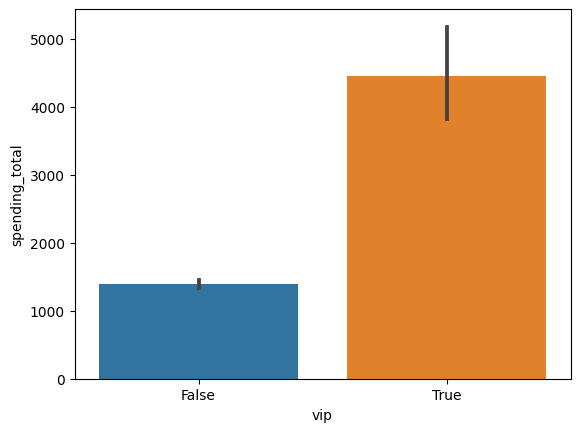

In [21]:
# Is there a relationship to spending and VIP status?
df['spending_total'] = df[spending_cols].sum(axis=1)
sns.barplot(data=df, x='vip', y='spending_total')
plt.show()

<AxesSubplot: xlabel='homeplanet', ylabel='vip'>

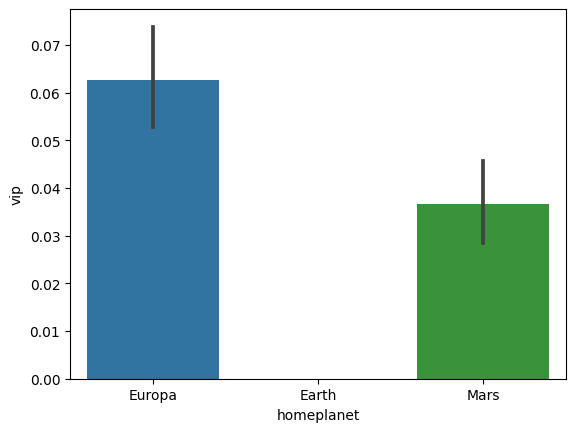

In [22]:
# Is there a relationship to homeplanet and VIP status?
sns.barplot(data=df, y='vip', x='homeplanet')

In [23]:
# What is the overall distribution of VIP status?
df.vip.value_counts(dropna=False)

False    8291
NaN       203
True      199
Name: vip, dtype: int64

Okay.. I should have asked that last question first.  There are only 199 known VIPs on the entire ship.. and there's only 203 passengers we don't know the VIP status of.  Since this is such a small subset of our data and it's much more likely that a passenger is not a VIP than is a VIP I think we can safely assume that anyone we don't know the VIP status of is not a VIP.

In [24]:
df.vip.fillna(False, inplace=True)
df.isna().sum()

passengerid         0
homeplanet        201
cryosleep           0
cabin             199
destination       182
age               179
vip                 0
roomservice         0
foodcourt           0
shoppingmall        0
spa                 0
vrdeck              0
name              200
transported         0
spending_total      0
dtype: int64

### Imputing `homeplanet`

I'm thinking Imight be able to simply lookup most of the `homeplanet` values by simply looking for other passengers in the same group as identified by `passengerid`

In [25]:
df[df.homeplanet.isna()]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total
59,0064_02,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,0.0,0.0,0.0,Colatz Keen,True,0.0
113,0119_01,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,9307.0
186,0210_01,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,0.0,0.0,0.0,Arraid Inicont,True,0.0
225,0242_01,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,1288.0
234,0251_01,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,9084_01,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False,1299.0
8613,9194_01,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,NaN,False,7177.0
8666,9248_01,NaN,False,F/1792/S,55 Cancri e,38.0,False,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True,2416.0
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,1148.0


In [26]:
df['group'] = df.passengerid.str.split('_', expand=True)[0].astype(int)

In [27]:
df[df['group'] == 9257]


,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total,group
8674,9257_01,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,1148.0,9257


In [28]:
df[df['group'] == 9274]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total,group
8684,9274_01,NaN,True,G/1508/P,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Chelsa Bullisey,True,0.0,9274


It looks like this idea isn't going to be very reliable.  Let's check the distribution of values.

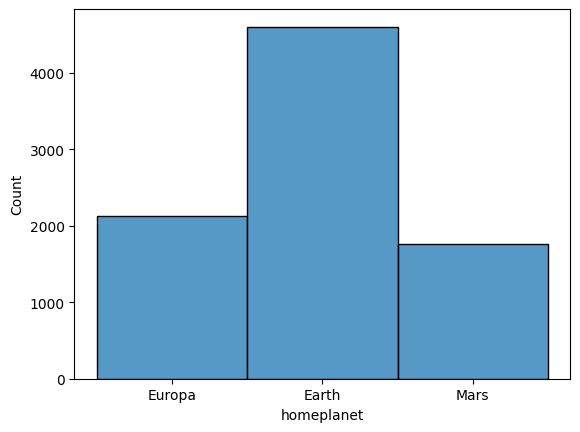

Earth     0.541922
Europa    0.250942
Mars      0.207136
Name: homeplanet, dtype: float64

In [29]:
sns.histplot(df['homeplanet'])
plt.show()
df['homeplanet'].value_counts(normalize=True)

It's more likely that someone is coming from Earth than not Earth.  Given that there are only ~200 nulls in this column, I think it's safe enough to just impute the mode for any missing values.

In [30]:
# Train the imputer
from sklearn.impute import SimpleImputer
homeplanet_imputer = SimpleImputer(strategy='most_frequent')
# Reshape your data using array.reshape(-1, 1) if your data has a single feature
column = df['homeplanet'].to_numpy().reshape(-1, 1)

homeplanet_imputer.fit(column)
imputed_homeplanet = homeplanet_imputer.transform(column)

df['homeplanet'] = imputed_homeplanet
df.isna().sum()

passengerid         0
homeplanet          0
cryosleep           0
cabin             199
destination       182
age               179
vip                 0
roomservice         0
foodcourt           0
shoppingmall        0
spa                 0
vrdeck              0
name              200
transported         0
spending_total      0
group               0
dtype: int64

### Imputing `destination`

In [31]:
df[df.destination.isna()]

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total,group
47,0045_02,Mars,True,F/10/P,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,Mass Chmad,True,0.0,45
128,0138_02,Earth,False,E/5/P,NaN,34.0,False,0.0,22.0,0.0,564.0,207.0,Monah Gambs,False,793.0,138
139,0152_01,Earth,False,F/32/P,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,Andan Estron,False,607.0,152
347,0382_01,Earth,False,G/64/P,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,Blanie Floydendley,False,720.0,382
430,0462_01,Earth,True,G/67/S,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,Ronia Sosanturney,False,0.0,462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8372,8956_02,Earth,True,G/1453/P,NaN,20.0,False,0.0,0.0,0.0,0.0,0.0,Erina Bonnondry,True,0.0,8956
8551,9130_01,Mars,True,F/1765/S,NaN,41.0,False,0.0,0.0,0.0,0.0,0.0,Blers Corte,True,0.0,9130
8616,9195_02,Mars,True,F/1779/S,NaN,33.0,False,0.0,0.0,0.0,0.0,0.0,Ceros Purle,True,0.0,9195
8621,9197_02,Europa,False,C/308/P,NaN,41.0,True,0.0,7964.0,0.0,3238.0,5839.0,Aludram Platch,False,17041.0,9197


I'm pretty sure I can get away with imputing `destination` similarly to how I imputed `homeplanet`.  However, I'm curious if there's a better way.  I want to ask a couple of questions first.
- Do people originating from a certain `homeplanet` favor a certain `destination`?
- Does the `cabin` information relate to `destination` (or maybe `homeplanet`)?

In [32]:
# Do people originating from a certain `homeplanet` favor a certain `destination`?
df.groupby(["homeplanet", "destination"])\
    .agg({"passengerid" : "count"})\
    .groupby(level=0, group_keys=False).apply(lambda x: 100*x/x.sum())\
    .sort_values(by=["homeplanet", "passengerid"], ascending=[False, False])

passengerid
homeplanet destination               
Mars       TRAPPIST-1e      85.905649
           55 Cancri e      11.240536
           PSO J318.5-22     2.853815
Europa     TRAPPIST-1e      56.781280
           55 Cancri e      42.311366
           PSO J318.5-22     0.907354
Earth      TRAPPIST-1e      69.170213
           PSO J318.5-22    15.489362
           55 Cancri e      15.340426

It looks like TRAPPIST is the most popular destination.  However, people from Europa seem to like Cancri almost as much as TRAPPIST.  PSO doesn't seem to be very popular at all except if you are from earth.

#### Expanding cabin info

There's some potentially useful information in the cabin column that I want to put into its own column.

In [33]:
cabin_expanded = df['cabin'].str.split('/', expand=True)\
    .rename(columns={0:'deck',1:'room',2:'side'})

df = pd.concat([df, cabin_expanded], axis=1)
df

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total,group,deck,room,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0,1,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,736.0,2,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,10383.0,3,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,5176.0,3,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1091.0,4,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,8536.0,9276,A,98,P
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0,9278,G,1499,S
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1873.0,9279,G,1500,S
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4637.0,9280,E,608,S


With that out of the way, let's see if there's a relationship to destination and cabin assignment.

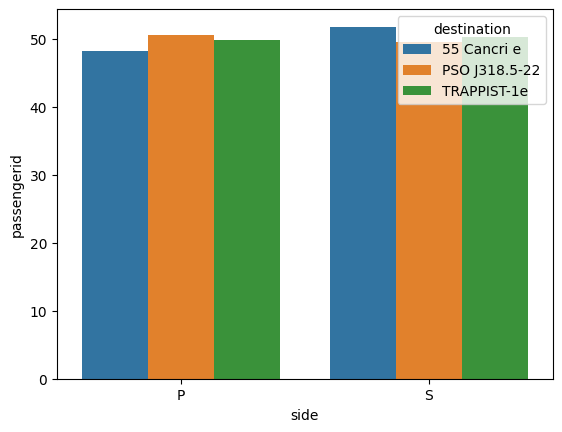

In [34]:
plot_data = df.groupby(["destination", "side"])\
    .agg({"passengerid" : "count"})\
    .groupby(level=0, group_keys=False).apply(lambda x: 100*x/x.sum())\
    .reset_index()

sns.barplot(data=plot_data, hue='destination', x='side', y='passengerid')
plt.show()

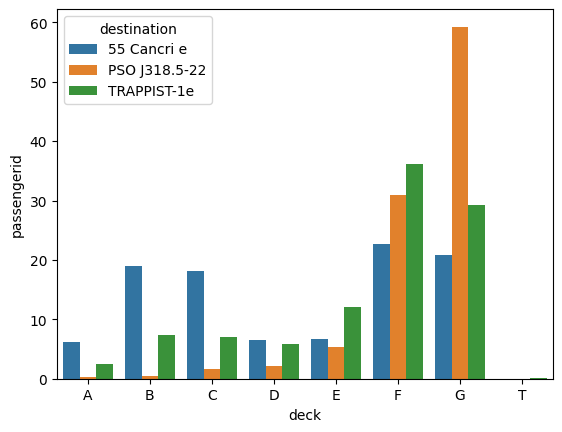

In [35]:
plot_data = df.groupby(["destination", "deck"])\
    .agg({"passengerid" : "count"})\
    .groupby(level=0, group_keys=False).apply(lambda x: 100*x/x.sum())\
    .reset_index()

sns.barplot(data=plot_data, hue='destination', x='deck', y='passengerid')
plt.show()

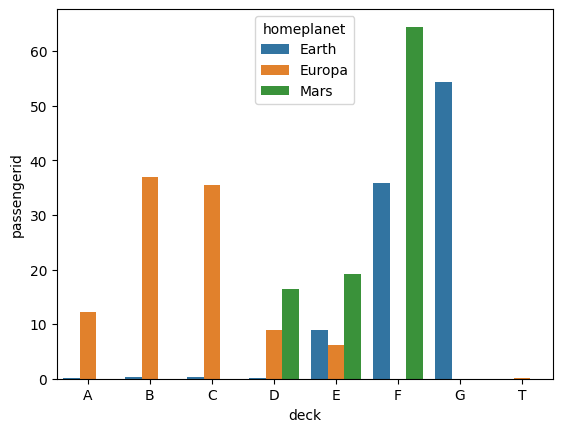

In [36]:
plot_data = df.groupby(["homeplanet", "deck"])\
    .agg({"passengerid" : "count"})\
    .groupby(level=0, group_keys=False).apply(lambda x: 100*x/x.sum())\
    .reset_index()

sns.barplot(data=plot_data, x='deck', hue='homeplanet', y='passengerid')
plt.show()

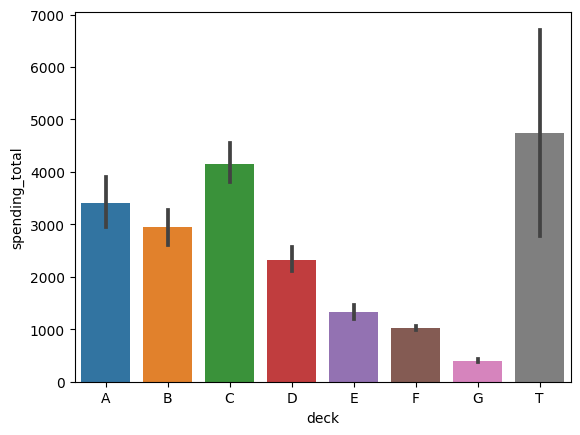

In [44]:
sns.barplot(data=df.sort_values(by='deck'), x='deck', y='spending_total')
plt.show()

In [45]:
df[df['deck']=='T']

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,spending_total,group,deck,room,side,total_spending
1004,1071_01,Earth,False,T/0/P,TRAPPIST-1e,35.0,False,415.0,1328.0,0.0,14.0,60.0,Alraida Dingauge,False,1817.0,1071,T,0,P,1817.0
2254,2414_01,Europa,False,T/1/P,TRAPPIST-1e,42.0,False,0.0,1829.0,2.0,3133.0,2447.0,Mergak Headfair,False,7411.0,2414,T,1,P,7411.0
2734,2935_01,Europa,False,T/2/P,TRAPPIST-1e,33.0,False,0.0,28.0,0.0,6841.0,543.0,NaN,False,7412.0,2935,T,2,P,7412.0
2763,2971_01,Europa,False,T/3/P,TRAPPIST-1e,38.0,False,0.0,3135.0,0.0,26.0,3.0,Pent Sessiouse,True,3164.0,2971,T,3,P,3164.0
4565,4863_01,Europa,False,T/2/S,TRAPPIST-1e,37.0,False,1721.0,667.0,130.6,28.0,1362.0,Phacton Unsible,False,3908.6,4863,T,2,S,3908.6
